# Introduction to Contextual Bandits

### In this Notebook, we'll examine two ways of constructing and using contextual bandits. Once for a simple classification task using a library, then a very simple dynamic pricing use case with a custom solution.

## ContextualBandits

### We're working with the BibTex dataset, which you can get information on [here.](http://mlkd.csd.auth.gr/publication_details.asp?publicationID=278)

In [2]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file
from tqdm import tqdm
import matplotlib.pyplot as plt

def parse_data(filename):
    with open(filename, "rb") as f:
        infoline = f.readline()
        infoline = re.sub(r"^b'", "", str(infoline))
        n_features = int(re.sub(r"^\d+\s(\d+)\s\d+.*$", r"\1", infoline))
        features, labels = load_svmlight_file(f, n_features=n_features, multilabel=True)
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    features = np.array(features.todense())
    features = np.ascontiguousarray(features)
    return features, labels

X, y = parse_data("Bibtex_data.txt")
print(f"Number of data points: {X.shape[0]}, number of features: {X.shape[1]}, number of classes: {y.shape[1]}")

Number of data points: 7395, number of features: 1836, number of classes: 159


### The ContextualBandits lib allows you to use any classifier or regressor you're already familiar with, the only requirements are the presence of certain functions. Since the lib only deals with discrete rewards (r ∈ {0,1}), all non-zero rewards will be treated as 1.

In [3]:
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import BootstrappedUCB
from copy import deepcopy

nchoices = y.shape[1] #The number of arms for our Bandit
base_algorithm = LogisticRegression(solver='lbfgs', warm_start=True, n_jobs=8) #Anything could go here, depending on our use-case
beta_prior = ((5./nchoices, 4), 2) # Prior assumed distribution of rewards


bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices,
                                   beta_prior = beta_prior, percentile = 80,
                                   random_state = 1111)

### Batch training works with bandits just as well as it does with any other ML system. Usually, the first actions of a bandit are randomised manually, to allow it to start learning on something.

In [4]:

rewards = []

batch_size = 50

first_batch = X[:batch_size, :]
np.random.seed(1)
actions_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), actions_chosen]

bootstrapped_ucb.fit(X=first_batch, a=actions_chosen, r=rewards_received)

### After this, we can go through the entire dataset and keep repeating these steps.

That is:
1. Get another batch of inputs
2. Compute the chosen actions
3. Compute the rewards
4. Pass all input-action-reward tuples currently available to the algorithm for learning

#### It is important to note about contextual bandits that they can be treated just like any other ML system.
They can be trained in batches, have inputs, a single output and a 'loss' function (called rewards here). Where you'll see them differ even at this level is their inclusion of a base algorithm, a traditional classifier for estimating the expected reward of each arm. As such, on this level, bandits are just another tool in your bag, not much more difficult to use than any other.

In [5]:
def simulate_rounds(model, rewards, actions_hist, X_global, y_global, batch_st, batch_end):
    
    actions_this_batch = model.predict(X_global[batch_st:batch_end, :]).astype('uint8')
    
    rewards.append(y_global[np.arange(batch_st, batch_end), actions_this_batch].sum())

    new_actions_hist = np.append(actions_hist, actions_this_batch)    

    model.fit(X_global[:batch_end, :], new_actions_hist, y_global[np.arange(batch_end), new_actions_hist],
              warm_start = True)
    
    return new_actions_hist


for i in tqdm(range(int(np.floor(X.shape[0] / batch_size)))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    actions_chosen = simulate_rounds(bootstrapped_ucb,
                                             rewards,
                                             actions_chosen,
                                             X, y,
                                             batch_st, batch_end)

100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [03:54<00:00,  1.60s/it]


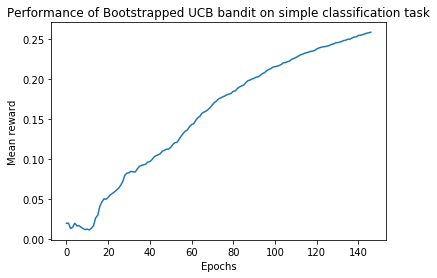

In [6]:
def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

plt.plot(get_mean_reward(rewards))
plt.title("Performance of Bootstrapped UCB bandit on simple classification task")
plt.xlabel("Epochs")
plt.ylabel("Mean reward")
plt.show()

#### Note that ContextualBandits has a built-in function for handling all the things we did here, called EvaluateFullyLabeled.

## In-house code

### The use case we're exploring here is the dynamic pricing one. The point of this short demo is to showcase what goes on behind the scenes in a bandit and where you can apply expert knowledge to create truly better ML Systems.

In a real use case, the price options for each product are determined by experts.
Another slot for expert knowledge is in the calculation of our UCBs: If someone was willing to buy a product at a certain price, they'd be willing to buy it at a lower price and if someone wasn't willing to a buy a product at a certain price, they won't be willing to buy it at a higher price either.

### Short description of the algorithm:
1. Generate prices for each product, observe profits and units sold
2. Calculate rewards: ‼Add fancy graph‼

    2.a For each price option, if smaller than the previously set price: minimum profit is (units sold * price)
    
    2.b If larger, maximum profit is (units sold * price)
3. Based on this, calculate expected profits
4. Choose optimal price for each product with epsilon chance, else choose randomly
5. Observe profits
6. Go to (2)

### Creating the simulation environment

#### We are going to have 20 user groups and 60 products. Each user group is made up of a number of different users and has a maximum price they're willing to buy a product at. Each product has a short range of possible prices.

In [18]:
import random
from math import floor

random.seed(600)

max_price = 20
number_of_users = 30

arms = [price for price in range(1, max_price)]

users = ([(random.randrange(1, max_price), True) for user in range(floor(number_of_users/2))] 
        + [(random.randrange(1, max_price), False) for user in range(floor(number_of_users/2))])

        
def generate_reward(users: list, price: int, rain: bool, temperature: int) -> int:
    """
    Generates the observed profit given users, the set price of the product and environmental effects
    
    Keyword arguments:
    users: List of tuples of (maximum acceptable price, rain tolerance)
    price: The price set for the product
    rain: Whether it's raining currently. Some users refuse to go out when it's raining
    temperature: The current temperature. Higher temperatures make people grumpy and raise their maximum acceptable price
    """
    reward = 0
    for user_preferences in users:
        if user_preferences[1]:
            if (user_preferences[0] * temperature) <= price:
                reward += price
    return reward

### Creating the bandit


#### The adjust_UCB function is responsible for the main logic of our bandit and for integrating our expert knowledge. Run_epoch is mostly for housekeeping.

In [19]:
from sklearn.linear_model import LinearRegression

estimated_overriding_profits = [0 for price in range(1, max_price)]

def adjust_overrides(fresh_reward, price, estimated_profits):
    for index, reward in enumerate(fresh_reward):
        potential_profit = index * fresh_reward['number_of_buyers']
        if index < price and estimated_profits[index] < potential_profit:
            estimated_profits[index] = potential_profit
        elif index == price:
            estimated_profits[index] = potential_profit
        elif index > price and estimated_profits[index] > potential_profit:
            estimated_profits[index] = potential_profit
    return estimated_profits

def choose_best_price(learned_estimates, overrides):
    return np.argmax([max(estimate, override) for estimate, override in zip(learned_estimates, overrides)])


                    
def run_epoch(overrides, product_max_price, users, epsilon, all_rewards, context, all_actions, estimators):
    chosen_price = 0
    if random.randrange(0, 100) <= epsilon: #This is our exploration strategy
        chosen_price = random.randrange(1, max_price)
    else: #Otherwise we go with our assumed best option
        estimations = compute_learned_estimations(estimators, )
        chosen_price = choose_best_price(estimations, overrides)
    rewards = generate_rewards(users, chosen_prices)
    ucbs = adjust_ucb(rewards, chosen_prices, products, ucbs)
    all_rewards.append(np.sum([reward['profit'] for reward in rewards]))
    return ucbs

In [12]:
max_epochs = 50
all_rewards = []
for epoch in tqdm(range(max_epochs)):
    #ucbs_global = run_epoch(ucbs_global, products, users, (1.0 / (epoch + 1)) * 100, all_rewards)
    ucbs_global = run_epoch(ucbs_global, products, users, 100, all_rewards)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.44it/s]


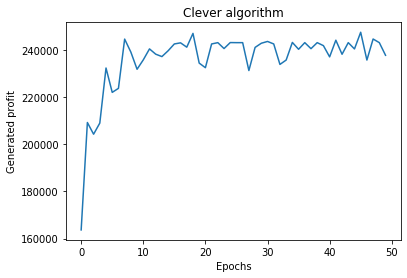

In [10]:
plt.plot(all_rewards)
plt.xlabel('Epochs')
plt.ylabel('Generated profit')
plt.title('Clever algorithm')
plt.show()

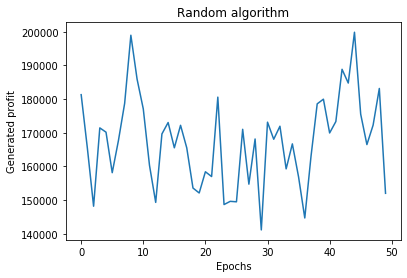

In [13]:
plt.plot(all_rewards)
plt.xlabel('Epochs')
plt.ylabel('Generated profit')
plt.title('Random algorithm')
plt.show()